# Torus-shaped Gaussian example

In this notebook we use `Ridge` to evaluate a torus-shaped probability distrbution constructed using a bivariate normal distribution defined in cylindrical coordinates:
$$
P(x, y, z | R_0, \epsilon) \propto \exp{\left(-\frac{(\rho - R_0)^2 + z^2}{2 \epsilon R_0}\right)}, \quad \quad \rho = \sqrt{x^2 + y^2}.
$$

In [1]:
from numpy import sqrt, array, ndarray, exp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ridge import Ridge
from ridge.plotting import plot_marginal_2d

To evaluate the distribution `Ridge` requires a function which returns the posterior log-probability up to an addative constant. The following class implements the required log-probability function for the above distribution:

In [2]:
class ToroidalGaussian:
    def __init__(self):
        self.R0 = 1.0  # major radius of the torus
        self.eps = 0.10  # aspect ratio of the torus
        self.coeff = -0.5 / (self.R0 * self.eps) ** 2

    def __call__(self, theta: ndarray) -> float:
        x, y, z = theta
        r_sqr = z**2 + (sqrt(x**2 + y**2) - self.R0) ** 2
        return self.coeff * r_sqr

We also need to specify how the parameter space (in this case the space of $x, y, z$) is discretised. This is done by specifying an 'origin' point, a spacing for each variable and optionally lower and upper bounds:

In [3]:
grid_spacing = array([0.04, 0.04, 0.02])  # the grid spacing for each variable
grid_centre = array([0.0, 0.0, 0.0])  # the 'origin' point of the grid
grid_bounds = array([[-1.5, -1.5, -0.5], [1.5, 1.5, 0.5]]).T

We can now create an instance of the `Ridge` class:

In [4]:
grid = Ridge(
    spacing=grid_spacing,
    offset=grid_centre,
    bounds=grid_bounds
)

To evaluate the posterior, we can pass an instance of `ToroidalGaussian` to `Ridge.evaluate_posterior`:

In [5]:
posterior = ToroidalGaussian()
grid.evaluate_posterior(posterior=posterior)

 [ 64812 total evaluations, state is end ]     

We can get a useful overview of the posterior using `matrix_plot`, which plots all 1D and 2D marginal distributions:

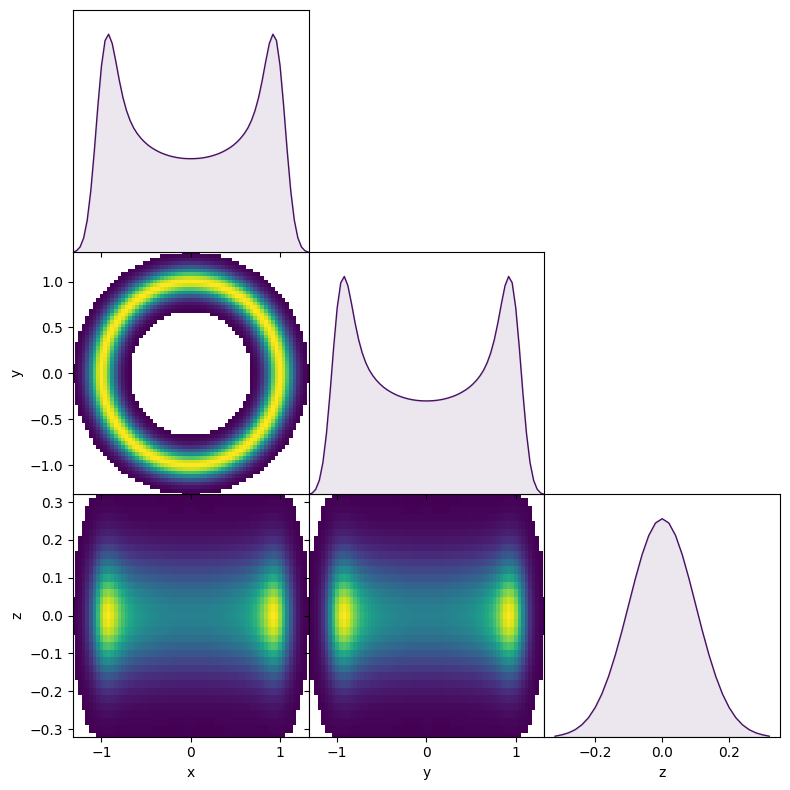

In [6]:
grid.matrix_plot(labels=["x", "y", "z"], colormap="viridis")

As `Ridge` aims to evaluate all cells in the parameter space with a non-negligible contribution to the total probability, we can efficiently generate samples from the distribution by sampling inside each evaluated cell based on their probabilities. This is implemented as the `generate_samples` method:

In [7]:
samples = grid.generate_samples(5000)

We can now plot the samples as points in $(x, y, z)$, colored by thier probabilities, to see the torus-shape of the distribution:

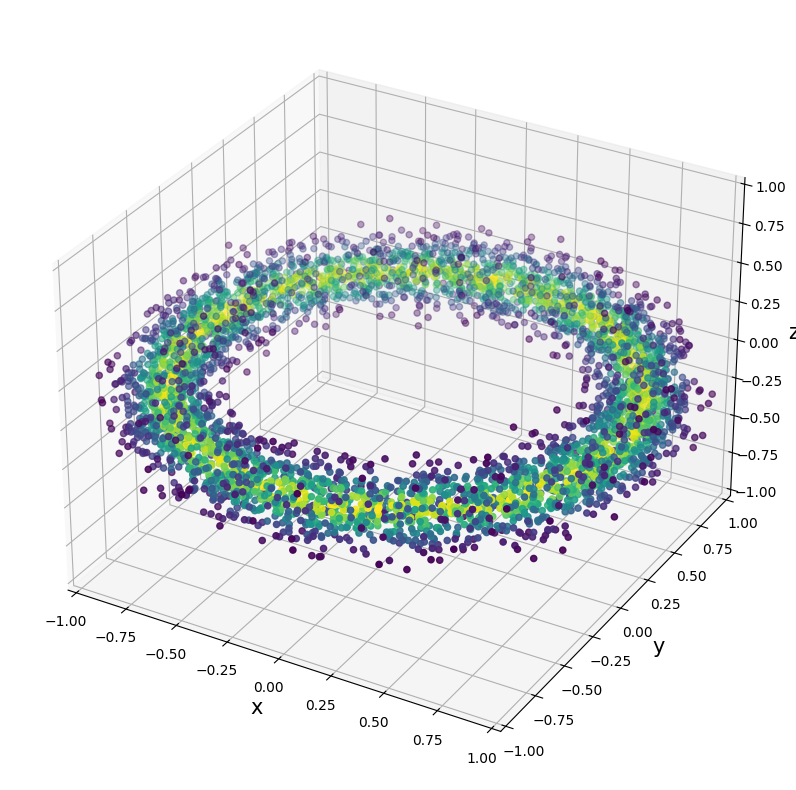

In [8]:
probs = array([posterior(s) for s in samples])
pnt_colors = exp(probs - probs.max()) # color the points by probability

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel("x", fontsize=15)
ax.set_ylabel("y", fontsize=15)
ax.set_zlabel("z", fontsize=15)
ax.scatter(*samples.T, c=pnt_colors)
plt.tight_layout()
plt.show()

`Ridge` functions by evaluating all cells above a given probability density threshold, and then iteratively lowering that threshold until the total probability of the evaluated cells converges. That convergence is tracked using the ratio of the fractional change in total probability to the fractional change in total cell evaluations between each iteration. Plots summarising the convergence can be generated using the `plot_convergence` method:

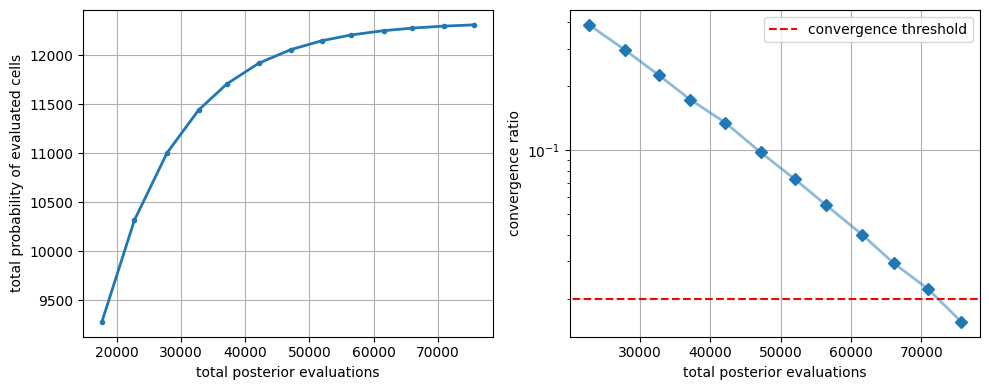

In [9]:
grid.plot_convergence()

Any of the possible marginal distributions can be calculated using the `get_marginal` method by passing a list of indices specifying which variables are part of the marginal. For example, to obtain the marginal distribution for the $x$ variable (index zero) we do the following:

In [10]:
points, probs = grid.get_marginal([0])

Now plot the calculated marginal:

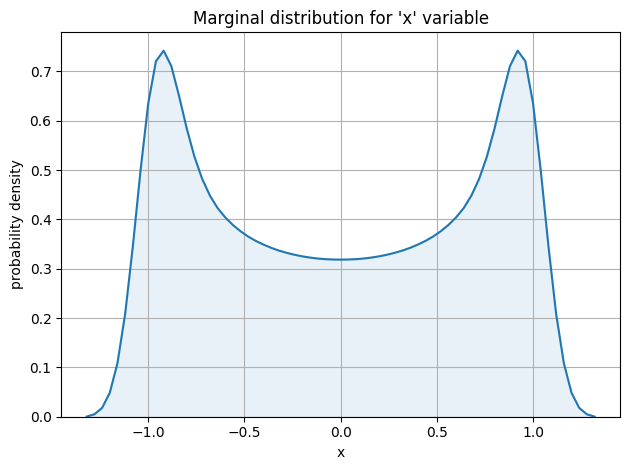

In [11]:
plt.plot(points, probs)
plt.fill_between(points, 0.0, probs, color="C0", alpha=0.1)
plt.xlabel("x")
plt.ylabel("probability density")
plt.title("Marginal distribution for 'x' variable")
plt.grid()
plt.ylim([0, None])
plt.tight_layout()
plt.show()

Similarly we can get the 2D marginal for $x$ and $y$ using

In [12]:
points, probs = grid.get_marginal([0, 1])

The `plot_marginal_2d` function from the `ridge.plotting` module is available to conveniently plot calculated 2D marginal distributions:

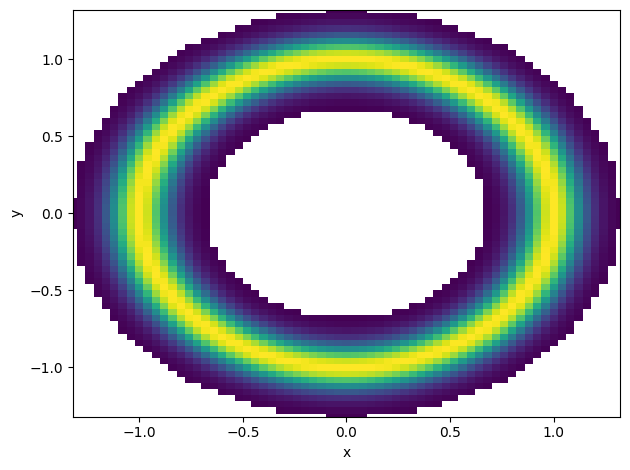

In [13]:
plot_marginal_2d(
    points=points,
    probabilities=probs,
    labels=["x", "y"],
)